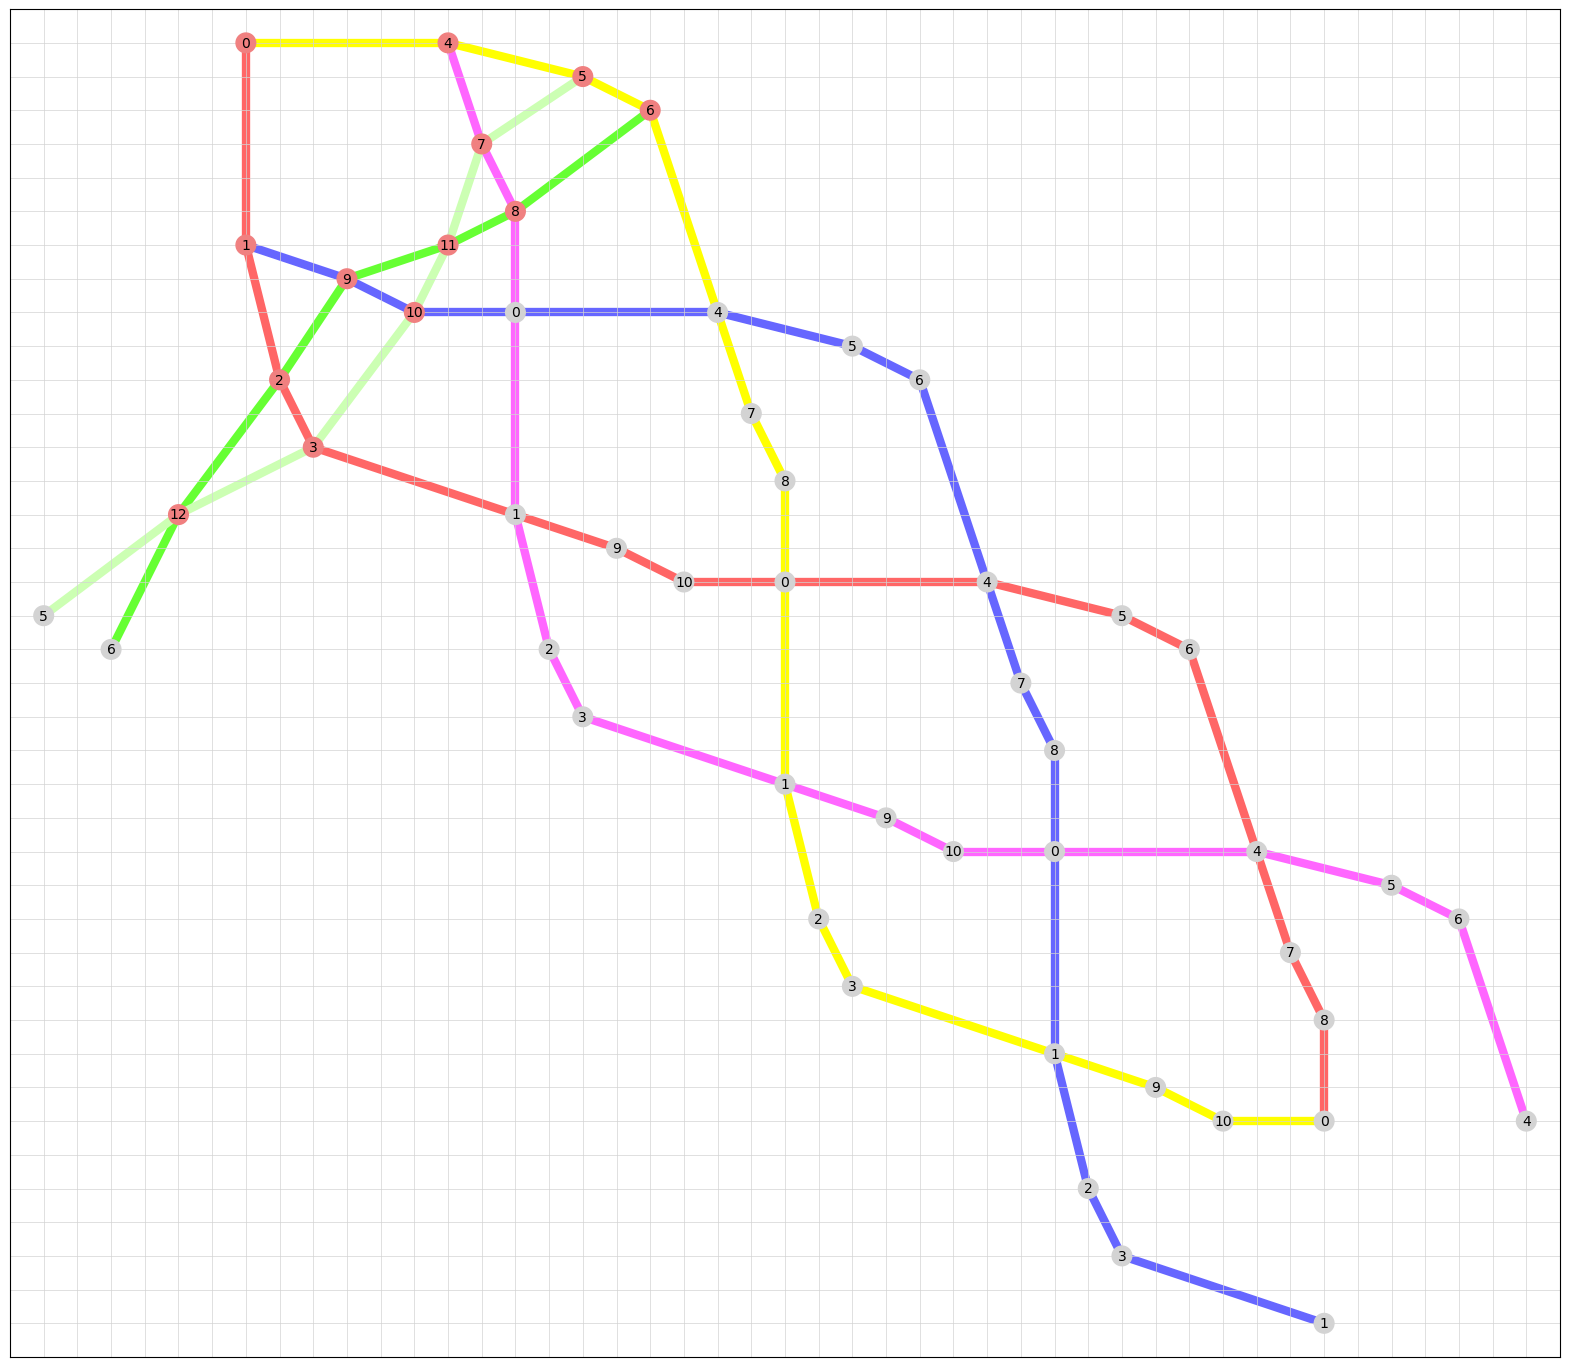

In [212]:
import json
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
%matplotlib inline

def load_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return data

def visualize_graph(filepath):
    data = load_data(filepath)
    
    # Create the graph
    G = nx.Graph()
    node_colors = {}  
    label_dict = {}  # Dictionary for custom labels

    for node_id, pos in data['nodes'].items():
        rounded_pos = tuple(round(p, 2) for p in pos)  # Round to nearest hundredth
        G.add_node(str(node_id), pos=rounded_pos)
        node_colors[str(node_id)] = 'lightcoral'
        label_dict[node_id] = str(node_id)

    pos_to_node_id = {tuple(G.nodes[node]['pos']): node for node in G.nodes()}
    
    # Define colors for different paths for clarity
    path_colors = ['#ff6666', '#6666ff', '#ffff00', '#ff66ff', '#66ff33', '#ccffb3', 'black']

    # Establish paths and shifts
    paths = {}
    for index, path_info in enumerate(data['paths']):
        path = path_info['path']
        paths[index] = path
        shifts = path_info['shifts']

    # Plot unit yarns with specified path starts and shifts
    plt.figure(figsize=(20, 20))
    for yarn_id, yarn_data in data['unit_yarns'].items():
        path_id = yarn_data[0]
        node_start_index = yarn_data[1]
        path_start_index = yarn_data[2]
        yarn_path = paths[path_id]

        # Adjust path for starting point within pattern
        adjusted_path = yarn_path[path_start_index:-1] + yarn_path[:path_start_index]
        current_pos = np.array(G.nodes[str(node_start_index)]['pos'], dtype=float)  # Ensure position is float
        cumulative_shift = np.array([0.0, 0.0])  # Initialize cumulative shift as float
        
        for i in range(len(adjusted_path)): # excluding last point of the path since it is cyclic
            node_start = str(adjusted_path[i % len(adjusted_path)])
            node_end = str(adjusted_path[(i + 1) % len(adjusted_path)])
            shift_key = f"[{node_start}, {node_end}]"
            current_shift = np.array(data['paths'][path_id]['shifts'].get(shift_key, (0, 0)), dtype=float)
            cumulative_shift += current_shift
            end_pos = np.array(G.nodes[node_end]['pos'], dtype=float) + cumulative_shift
            rounded_pos = tuple(round(p, 2) for p in end_pos)
            
            if rounded_pos not in pos_to_node_id:
                new_node = str(end_pos)+'_'+str(rounded_pos[0])+'_'+str(rounded_pos[1])
                G.add_node(new_node, pos=tuple(rounded_pos))  # Ensure pos is tuple as your nodes expect
                node_colors[new_node] = 'lightgray'
                label_dict[new_node] = node_end
                pos_to_node_id[rounded_pos] = new_node
            G.add_edge(pos_to_node_id.get(tuple(current_pos)), pos_to_node_id.get(tuple(end_pos)), color=path_colors[int(yarn_id) % len(path_colors)], linewidth=2)
            current_pos = end_pos

    # Draw the graph
    colors = [node_colors[node] for node in G.nodes()]
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]

    pos = nx.get_node_attributes(G, 'pos')
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=200)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=6)    
    nx.draw_networkx_labels(G, pos, labels=label_dict, font_size=10, font_family='sans-serif')

    # Set grid spacing

    grid_spacing = 1  # Grid lines at every 1 unit
    plt.gca().set_xticks(np.arange(min(x for x, _ in pos.values()) - 1, max(x for x, _ in pos.values()) + 1, grid_spacing))
    plt.gca().set_yticks(np.arange(min(y for _, y in pos.values()) - 1, max(y for _, y in pos.values()) + 1, grid_spacing))
    
    # Enable the grid
    plt.grid(True, which='both', linestyle='-', linewidth=0.5, color='lightgray')

    # Set limits and equal aspect ratio to ensure the grid lines are square if desired
    plt.xlim([min(x for x, _ in pos.values()) - 1, max(x for x, _ in pos.values()) + 1])
    plt.ylim([min(y for _, y in pos.values()) - 1, max(y for _, y in pos.values()) + 1])
    plt.gca().set_aspect('equal', adjustable='box')

    # Invert y-axis if required by your coordinate preferences
    plt.gca().invert_yaxis()
    plt.show()
    
# Call the visualization function with the path to your JSON file
visualize_graph('input/json_patterns/pattern2020.json')